### Empirical Example for RobustiPY (Type 1)!

#### This example is designed to show how basic functionality -- such as OLS can be used with a cross-sectional dataset -- works.

In [1]:
import os # for filepath handling
import pandas as pd
import requests # for grabbing the dataset
import matplotlib.pyplot as plt # for plotting
from robustipy.models import OLSRobust

Create a wrapper to grab the data:

In [2]:
def get_data():
    os.makedirs(os.path.join('..',
                             'data',
                             'ehrlich_example',
                            ),
                exist_ok=True
               )
    uscrime_path = os.path.join('..',
                                'data',
                                'ehrlich_example',
                                'uscrime.txt')
    if os.path.exists(uscrime_path):
        df = pd.read_csv(uscrime_path, sep=r"\s+")
    else:
        df = pd.read_csv("https://fermin.perso.math.cnrs.fr/Files/UScrime.txt",
                         sep=r"\s+", skiprows=35, index_col=0)
        df.to_csv(uscrime_path, sep='\t')
    df = df.rename({'M': 'Males',
                    'LF': 'Labour Force',
                    'W': 'Wealth',
                    'X': 'Inequality',
                    'U1': 'Unemployment',
                    'Ex0': 'Expenditure'}, axis=1)    
    return df

Get the data, and look at its header:

In [3]:
df = get_data()
df.reset_index(drop=False, inplace=True)
df.head()

,index,R,Age,Ed,Expenditure,Ex1,Labour Force,Males,N,NW,Unemployment,U2,Wealth,Inequality
0,0,79.1,151,91,58,56,510,950,33,301,108,41,394,261
1,1,163.5,143,113,103,95,583,1012,13,102,96,36,557,194
2,2,57.8,142,89,45,44,533,969,18,219,94,33,318,250
3,3,196.9,136,121,149,141,577,994,157,80,102,39,673,167
4,4,123.4,141,121,109,101,591,985,18,30,91,20,578,174


Do some RobustiPy things:

In [4]:
ehrlich_robust = OLSRobust(y=['R'], x=['Inequality'], data=df)
ehrlich_robust.fit(controls=['Expenditure',
                             'Age',
                             'Ed',
                             'Unemployment',
                             'Males',
                             'N',
                             'Wealth'],
                   draws=1000,
                   kfold=10,
                   oos_metric='pseudo-r2',
                   seed=192735,
                  )

You haven’t specified the number of CPUs. Is 31 okay? (yes/no):  yes


Output()

OLSRobust is running with n_cpu=31, draws=1000, folds=10, seed=192735.
We're evaluating our out-of-sample predictions with the pseudo-r2 metric.
The estimand of interest is Inequality. Let's begin the calculations...


Get the results:

In [5]:
ehrlich_results = ehrlich_robust.get_results()

Plot them:

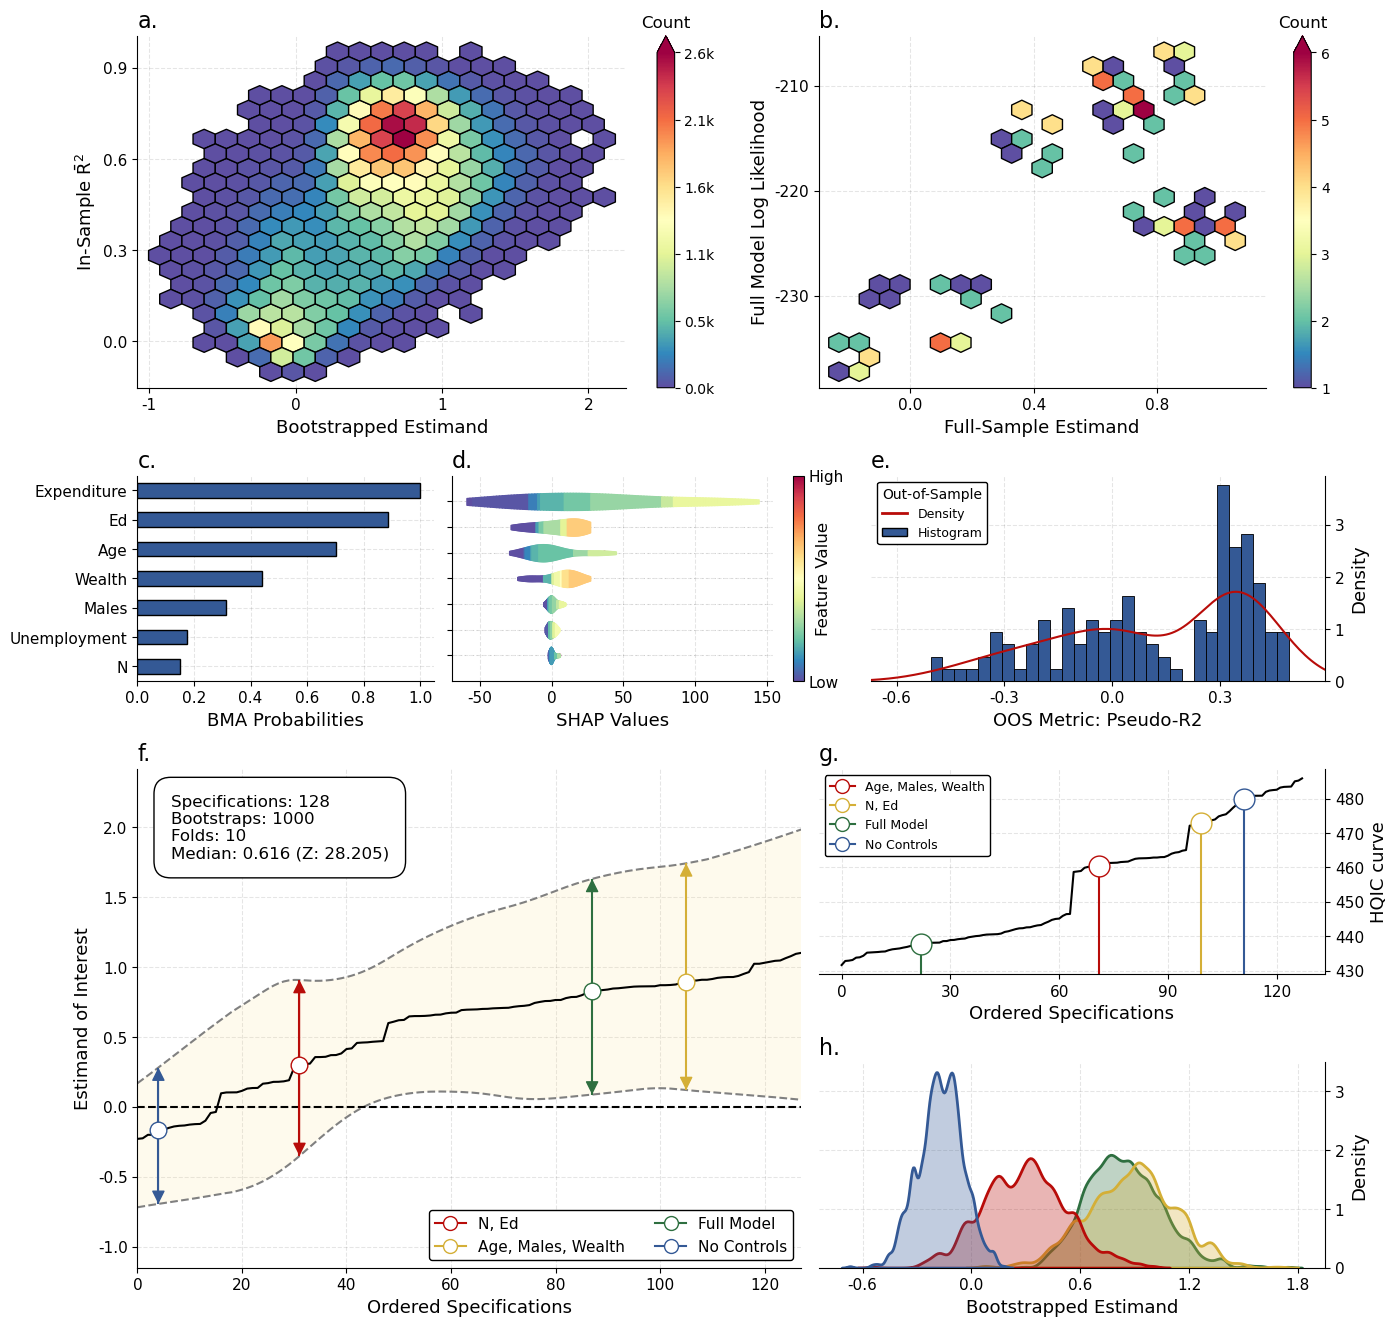

In [6]:
ehrlich_results.plot(specs=[['Ed', 'N'],
                            ['Age', 'Males', 'Wealth']],
                     ic='hqic',
                     ci=1,
                     ext='pdf',
                     project_name='ehrlich_example',
                     figpath = '../figures',
                     figsize=(16, 16)
                    )

Summarize them (with six digits):

In [7]:
ehrlich_results.summary(digits=4)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: R
Independent variable: Inequality
Number of possible controls: 7
Number of draws: 1000
Number of folds: 10
Number of specifications: 128
2.Model Robustness Metrics
2.1 Inference Metrics
Median beta (all specifications, no resampling): 0.6976 (p-value: 0.0)
Median beta (all bootstraps and specifications): 0.616
Min beta (all specifications, no resampling): -0.2304
Min beta (all bootstraps and specifications): -0.9284
Max beta (all specifications, no resampling): 1.0851
Max beta (all bootstraps and specifications): 2.1078
AIC-weighted beta (all specifications, no resampling): 0.8116
BIC-weighted beta (all specifications, no resampling): 0.7296
HQIC-weighted beta (all specifications, no resampling): 0.7588
Significant portion of beta (all specifications, no resampling): 0.75 (p-value: 0.0)
Significant portion of beta (all bootstraps and specifications): 0.7336
Positive portion of beta (all specifications, no resa